In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
import scipy.optimize as optimize
from scipy import integrate
from matplotlib import rcParams

In [137]:
#Define parameters from paper

alpha_ptc = 0.024
gamma_p = 0.006
gamma_c = 0.1539
K_h = 2.2771
k_off = 0.3018
k_on = K_h * k_off
K_p = 0.5660
n_p = 0.9
alpha_R = 0.3908
gamma_R = 0.002
K_R = 8.5184
n_R = 1.5735
alpha_GBS = 5.6881e-3
alpha_GBS0 = 9.8715e-5
D_diff = 58.3931
alpha_HH = 0.5431
gamma_H = 8.1346e-4
beta = 36
m = 1.8657

P = 4(1+36(29.10169999684341/(29.10169999684341+(195.39999999999998((P^0.9)/((P^0.9) + 0.5991489300104573))))))

R = 195.39999999999998((23.2376^0.9)/((23.2376^0.9) + 0.5991489300104573))

gives us:

P = 23.2376

R = 188.735

In [341]:
def d_matrix(n):
    h = 1/(n-1)
    D = (-2*np.identity(n))/(h**2)
    for i in range(n-1):
        D[i, i+1] = 1/(h**2)
        D[i+1, i] = 1/(h**2)
    D[0] = 0
    return D

In [469]:
def delta_H(A, B, H, P, C, n, t, r): 
    
    b = r*H
    D = np.matmul(B, H) + b
    print(D)
    
    #print(A, D)
    
    delta = np.linalg.solve(A, D)
    
    delta_final = delta - (gamma_H*H) - (k_on*H*P) + (k_off*C)
    delta_final[n-1] = 0
    
    for i in range(n):
        if H[i] + (delta_final[i]*t) < 0:
            delta_final[i] = -H[i]/t
    return delta_final

def phi_R(R, n):
    phi = np.zeros(n)
    for i in range(n):
        phi[i] = (K_R**n_R)/((K_R**n_R)+(R[i]**n_R))
    return phi

def delta_P(H, P, R, C, n, t):
    delta = (alpha_ptc*np.ones(n)) + (alpha_ptc*beta*phi_R(R, n)) - (gamma_p*P) - (k_on*H*P) + (k_off*C)
    for i in range(n):
        if P[i] + (delta[i]*t) < 0:
            delta[i] = -P[i]/t
    return delta

def delta_C(H, P, C, n, t):
    delta = (k_on*H*P) - (k_off*C) - (gamma_c*C)
    for i in range(n):
        if C[i] + (delta[i]*t) < 0:
            delta[i] = -C[i]/t
    return delta

def delta_R(P, R, n, t):
    delta = np.zeros(n)
    for i in range(n):
        delta[i] = (alpha_R*(P[i]**n_p)/((K_p**n_p)-(P[i]**n_p))) - (gamma_R*R[i])
    for i in range(n):
        if R[i] + (delta[i]*t) < 0:
            delta[i] = -R[i]/t
    return delta

def delta_S(R, S, n, t):
    delta = (alpha_GBS0*np.ones(n)) - (alpha_GBS*phi_R(R, n))
    for i in range(n):
        if S[i] + (delta[i]*t) < 0:
            delta[i] = -S[i]/t
    return delta

In [470]:
def integrate_system(final_time, time_step, n):
    H = np.zeros(n)
    C = np.zeros(n)
    S = np.zeros(n)
    
    P = 23.2376*np.ones(n)
    R = 188.735*np.ones(n)
    step_P = np.inf
    step_R = np.inf
    tol = 0.001
    D = d_matrix(n)
    time = 0
    r = D_diff*time_step/((1-n)**2)
    
    A = np.zeros((n,n))
    B = np.zeros((n,n))
    for i in range(n-1):
        if i==0:
            A[i,:] = [2+2*r if j==0 else (-r) if j==1 else 0 for j in range(n)]
            B[i,:] = [2-2*r if j==0 else r if j==1 else 0 for j in range(n)]
        elif i==n-1:
            A[i,:] = [-r if j==N-4 else 2+2*r if j==N-3 else 0 for j in range(n)]
            B[i,:] = [r if j==N-4 else 2-2*r if j==N-3 else 0 for j in range(n)]
        else:
            A[i,:] = [-r if j==i-1 or j==i+1 else 2+2*r if j==i else 0 for j in range(n)]
            B[i,:] = [r if j==i-1 or j==i+1 else 2-2*r if j==i else 0 for j in range(n)]
    
    while time<final_time:
        H[0] += alpha_HH*time_step
        
        
        step_H = delta_H(A, B, H, P, C, n, time_step, r)
        step_P = delta_P(H, P, R, C, n, time_step)
        step_C = delta_C(H, P, C, n, time_step)
        step_R = delta_R(P, R, n, time_step)
        step_S = delta_S(R, S, n, time_step)
        
        H += time_step*step_H
        P += time_step*step_P
        C += time_step*step_C
        R += time_step*step_R
        S += time_step*step_S
        
        time += time_step
        
    return H, P, C, R, S

In [471]:
H, P, C, R, S = integrate_system(10, 0.5, 1000)

[5.43092056e-01 7.94420362e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

LinAlgError: Singular matrix

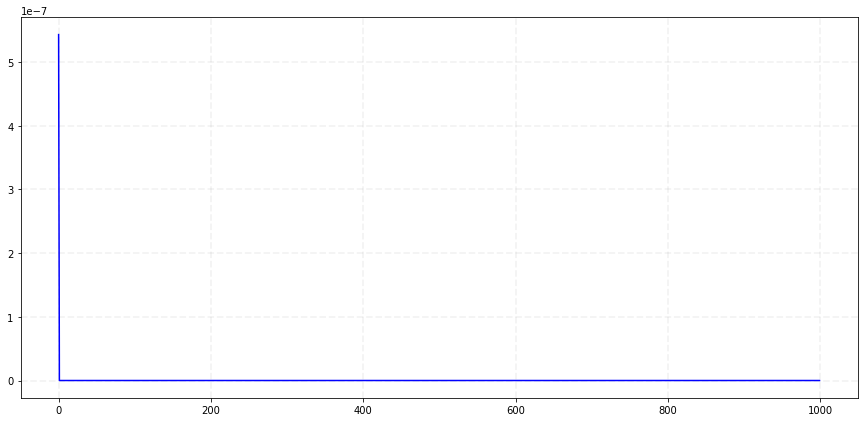

In [413]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.grid(True, lw=1.76, ls='--', alpha = 0.15)
plt.plot(H, '', color = 'b', ms =10)
plt.show()

In [439]:
n = 1000
A = np.zeros((n,n))
B = np.zeros((n,n))
for i in range(n-1):
    if i==0:
        A[i,:] = [2+2*r if j==0 else (-r) if j==1 else 0 for j in range(n)]
        B[i,:] = [2-2*r if j==0 else r if j==1 else 0 for j in range(n)]
        b[i] = 0. #boundary condition at i=1
    elif i==n-1:
        A[i,:] = [-r if j==N-4 else 2+2*r if j==N-3 else 0 for j in range(n)]
        B[i,:] = [r if j==N-4 else 2-2*r if j==N-3 else 0 for j in range(n)]
        b[i] = 0. #boundary condition at i=N
    else:
        A[i,:] = [-r if j==i-1 or j==i+1 else 2+2*r if j==i else 0 for j in range(n)]
        B[i,:] = [r if j==i-1 or j==i+1 else 2-2*r if j==i else 0 for j in range(n)]

In [440]:
A

array([[1000.001 , -499.0005,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [-499.0005, 1000.001 , -499.0005, ...,    0.    ,    0.    ,
           0.    ],
       [   0.    , -499.0005, 1000.001 , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [   0.    ,    0.    ,    0.    , ..., 1000.001 , -499.0005,
           0.    ],
       [   0.    ,    0.    ,    0.    , ..., -499.0005, 1000.001 ,
        -499.0005],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]])